# Pet Classification with CNN
<b>Student</b>: Lorenzo Severini<b>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Course</b>: Computer Vision and Image Processing M

# Project Overview
The goal of this project is to implement a neural network that classifies images of 37 breeds of cats
and dogs from the Oxford-IIIT-Pet dataset. The project is divided into two tasks: first, you will be
asked to implement from scratch your own neural network for image classification; then, you will
fine-tune a pre-trained network provided by Keras.

## Dataset
### Overview
The dataset you will be using contains images of pets.

![dataset overview](img-report/dataset-overview.png "Dataset OVeerview")

You can download the dataset at the following URL: https://www.robots.ox.ac.uk/~vgg/data/pets/.

### Content
The repository contains a 37-category pet dataset with roughly 200 images for each class. The
images have a large variation in scale, pose and lighting. All images have an associated ground
truth annotation of breed. The dataset is already split into training, validation and testing. You
should use only the training and validation splits for development in both the first and second tasks.

# First Task: design your own network
The goal is to implement a convolutional neural network for image classification and train it on
the <code>Oxford-IIIT-Pet Dataset</code>. You should consider yourself satisfied once you obtain a classification
accuracy on the validation split of around 60%. You are free to achieve that however you want,
except for a few rules you must follow:
<ul>
<li>You cannot simply instantiate an off-the-shelf Keras network. Instead, you must construct
your network as a composition of existing Keras layers;</li>
<li>Justify every design choice you make. Design choices include network architecture, training
hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from
the simplest convolutional network you can think of and add complexity one step at a time,
while showing how each step gets you closer to the target 60%, or (ii) start from a model
that is already able to achieve the desired accuracy and show how, by removing some of its
components, its performance changes. You can show your results however you want: training
plots, console-printed values or tables.</li>
</ul>
Don’t be too concerned with your network performance: the 60% is just to give you an idea of
when to stop.

## Environment
The necessary libraries are imported below.

To ensure the project is reproducible, random seeds are set for TensorFlow and NumPy.

In [ ]:
import os
import tarfile
import shutil
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# setting seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

Some hyperparameters are already defined here:
<ul>
    <li><b>Batch Size</b>: It is a compromise between the amount of VRAM available and the size of the architecture.
    <li><b>Epochs</b>: We set a high number (e.g., 200) because <code>EarlyStopping</code> will handle the actual stop point.</li>
    <li><b>Image Size</b>: Having a smaller image size may result in the loss of certain small features of the image (e.g., eyes): 224 seems a good compromise and it's vastly utilized in classification tasks.
</ul>

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)  
NUM_CLASSES = 37
NUM_EPOCHS = 200

## Paths
Configuration paths are defined here. The project uses a local directory structure to organize the data according to the official split files.

In [ ]:
# path configuration
dataset_dir_path = os.path.join('../', 'oxford-pet')

images_dir_path = os.path.join(dataset_dir_path, 'images')
annots_dir_path = os.path.join(dataset_dir_path, 'annotations')

# defining separate folders for the official splits
train_val_path = os.path.join(dataset_dir_path, 'train_val')
test_path = os.path.join(dataset_dir_path, 'test')

## GPU Compatibility and OS Selection
Native GPU support on Windows is strictly limited to TensorFlow 2.10. Due to configuration difficulties with this specific version, I opted to migrate the development environment to Linux. The final configuration consisted of using <b>Ubuntu via WSL2</b> (Windows Subsystem for Linux). Relying on my prior experience with Linux systems, this transition provided a much more convenient workflow and allowed the use of TensorFlow 2.15, ensuring proper GPU acceleration without compatibility issues.

Regarding hardware, the initial experiments (up to Test 5) were conducted using a <b>GTX 1650 (4GB VRAM)</b>. However, the limited video memory proved insufficient for this image classification task, restricting the batch size to very small values (2 or 4) to avoid Out-Of-Memory (OOM) errors. Since CPU training was inefficient, I switched to a workstation equipped with a <b>GTX 1080 (8GB VRAM)</b>. This upgrade allowed me to increase the batch size to 16, resulting in faster training times and more stable model convergence. 

In [ ]:
print(f"Python Version: {sys.version.split()[0]}")
print(f"TensorFlow Version: {tf.__version__}")
print("Device:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

try:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True) # tensorFlow starts by allocating only a small amount of memory and expands it (memory growth) as the model needs it during execution.
except RuntimeError:
    pass 

Python Version: 3.10.19
TensorFlow Version: 2.15.1
Device: GPU


## Dataset Download and Directories Preparation
We need to check for the existence of the <b>Oxford-IIIT-Pet Dataset</b> directory. If the data is missing, it downloads the archives, extracts them using tarfile, and removes the compressed files to save space.

In [21]:
def download_and_extract(url, dest_folder, filename):
    # create the folder if not exists
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    archive_path = os.path.join(dest_folder, filename)
    
    # downloading archive
    print(f"Downloading {filename}...")
    tf.keras.utils.get_file(
        fname=filename,
        origin=url,
        cache_dir='.', 
        cache_subdir=dest_folder # downloads directly into the folder
    )
    
    # extracting (python handles .tar.gz in one step)
    print(f"Extracting {filename}...")
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=dest_folder)
        
    # removing the zip file to clean up
    print(f"Removing {filename} to save space...")
    os.remove(archive_path)

# check if images exist
if not os.path.exists(images_dir_path):
    url_images = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
    download_and_extract(url_images, dataset_dir_path, 'images.tar.gz')
else:
    print("Images already present.")

# check if annotations exist
if not os.path.exists(annots_dir_path):
    url_annots = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"
    download_and_extract(url_annots, dataset_dir_path, 'annotations.tar.gz')
else:
    print("Annotations already present.")

Images already present.
Annotations already present.


## Dataset Split
Once we have downloaded and the dataset, a function called <code>create_split</code> is implemented. Instead of random splitting, this function parses the official annotation files (<code>trainval.txt</code> and <code>test.txt</code>).<br>
It reads each line to identify the filename and extracts the class name directly from the string (for example converting Abyssinian_1 to Abyssinian); it then copies the images into class-specific subfolders, creating a clean directory structure compatible with Keras.

In [22]:
# function to read text files and move images
def create_split(annots_filename, dest_path):
    # path to the list file (e.g. annotations/trainval.txt)
    annots_file_path = os.path.join(annots_dir_path, annots_filename)
    
    # check if destination already exists to avoid re-copying

    if os.path.exists(dest_path):
        print(f"Split {os.path.basename(dest_path)} already exists.")
        return

    print(f"Creating split in {dest_path}...")
    os.makedirs(dest_path, exist_ok=True)
    
    # reading the list file
    with open(annots_file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split()
        if not parts: continue
            
        # parsing the line: "Abyssinian_1 1 1 1"
        filename_no_ext = parts[0]
        filename = filename_no_ext + ".jpg"
        
        # getting class name (everything before the last underscore)
        # for example, "Abyssinian_1" -> "Abyssinian"
        class_name = "_".join(filename_no_ext.split('_')[:-1])
        
        # defining source and destination paths
        src_file = os.path.join(images_dir_path, filename)
        dest_folder = os.path.join(dest_path, class_name)
        dest_file = os.path.join(dest_folder, filename)
        
        # copy file only if it exists in source
        if os.path.exists(src_file):
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            shutil.copy(src_file, dest_file)

# executing the splits
# trainval.txt -> train_val folder
# test.txt -> test folder
if os.path.exists(images_dir_path) and os.path.exists(annots_dir_path):
    create_split('trainval.txt', train_val_path)
    create_split('test.txt', test_path)
    print("Dataset splitting complete.")
else:
    print("ERROR: images or annotations not found. Run the download block first.")

Split train_val already exists.
Split test already exists.
Dataset splitting complete.


## Data Preprocessing
Before loading the data, the preprocessing logic is defined. Since the dataset is small (almost 200 images per class), data preprocessing is required:
<ul>
    <li><b>Normalization</b>: Pixel values are cast to floats and scaled from the [0, 255] range to the [0, 1] range.</li>
    <li><b>Resizing</b>: Is automatically done while creating the image of the dataset.</li>
    <li><b>Augmentation</b>: Random transformations (flip, rotation, zoom) are inside the model (only if training).</li>
</ul>

In [ ]:
# applies normalization
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Data Loading
Now that the data is organized in the <code>train_val</code> folder, <code>tf.keras.utils.image_dataset_from_directory</code> is used to load the images.
<br> A further split is needed to monitor performance during training: 
<ul>
    <li><b>80%</b> of the data will be used for <b>training</b>.</li>
    <li><b>20%</b> of the data will be used for <b>validation</b>.</li>
</ul>

The test folder created in the previous step is not used here, as per the project requirements.

The <code>.map()</code> function is used to to apply these transformations (in this case just normalization), <code>.cache()</code> to keep images in memory after the first epoch and <code>.prefetch(buffer_size=tf.data.AUTOTUNE)</code> to prepare the next batch while the GPU is processing the current one.

<i>Note: We apply the mapping <b>after</b> the <code>cache()</code> operation. This ensures that the base images are loaded from memory once. If there was data augmgentation it still would have been computed runtime at every epoch.</i>

In [ ]:
print(f"Loading data from: {train_val_path}")

AUTOTUNE = tf.data.AUTOTUNE

# training dataset
print("Creating Training Split...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True
)

# saving class names before transformations
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes found: {num_classes}")

# optimized training pipeline
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()       # keeps in RAM after first epoch
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

# # validation dataset
print("Creating Validation Split...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_val_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=None, # None qui
    shuffle=False
)

# optimized validation pipeline
val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("Data pipeline finalized.")

Loading data from: ./oxford-pet/train_val
Creating Training Split...
Found 3680 files belonging to 37 classes.
Using 2944 files for training.
Classes found: 37
Creating Validation Split...
Found 3680 files belonging to 37 classes.
Using 736 files for validation.
Data pipeline finalized.


## Model Architecture
The project requires building a network from scratch using Keras layers. To ensure modularity and cleaner code, the Subclassing API is being used to define both the residual blocks and the full classifier model. This approach provides flexibility and control over the network's forward pass, facilitating the implementation of custom logic like skip connections and conditional execution (e.g., training-only augmentation).

### Key Components
<ul>
    <li><b>Dual Convolution Paths</b>: The main path consists of two sequences of <code>Conv2D</code> &rarr; <code>BatchNormalization</code> &rarr; <code>ReLU</code>.</li>
    <li><b>Skip Connection</b>: The input to the block (<code>residual</code>) is added to the output of the second convolution layer.</li>
    <li><b>Dimension Matching</b>: If the number of filters in the input differs from the output filters, a 1x1 convolution (<code>shortcut_conv</code>) is applied to the residual path to align dimensions before addition.</li>
    <li><b>Optional Pooling</b>: A <code>MaxPooling2D</code> layer can be optionally included at the end of the block to reduce spatial dimensions, controlled by the pool argument.</li>
</ul>

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PetBlock(layers.Layer):
    def __init__(self, filters, kernel_size, pool=True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.pool = pool

        #  component
        self.conv1 = layers.Conv2D(filters,
                                   kernel_size,
                                   padding='same',
                                   kernel_initializer='he_uniform',
                                   use_bias=False,
                                   )
        self.bn1 = layers.BatchNormalization()
        
        self.act1 = layers.Activation('relu')

        # second component
        self.conv2 = layers.Conv2D(filters,
                                   kernel_size,
                                   padding='same',
                                   kernel_initializer='he_uniform',
                                   use_bias=False,
                                   )
        self.bn2 = layers.BatchNormalization()
        
        self.act2 = layers.Activation('relu')

        # shortcut path (1x1 conv) for dimension matching
        self.shortcut_conv = layers.Conv2D(filters,
                                           1,
                                           padding='same',
                                           use_bias=False,
                                           kernel_initializer='he_uniform')
        self.shortcut_bn = layers.BatchNormalization()

        self.max_pool = layers.MaxPooling2D() if pool else None

    def call(self, inputs, training=False):
        residual = inputs # save input for addition

        # first cycle
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        # second cycle
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # match dimensions if input channels != filters
        if inputs.shape[-1] != self.filters:
            residual = self.shortcut_conv(residual)
            residual = self.shortcut_bn(residual, training=training)

        # skip connection: add original input to output
        x = layers.add([x, residual])
        x = self.act2(x) # relu applies to the sum

        if self.max_pool:
            x = self.max_pool(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            "pool": self.pool,
        })
        return config

### PetClassifier (Model)

The PetClassifier class assembles the full Convolutional Neural Network. It integrates data augmentation, a stem block for initial feature extraction, a stack of PetBlocks for deep feature learning, and a classification head.

<ul>
    <li><b>Data Augmentation</b>: Layers such as <code>RandomFlip</code>, <code>RandomRotation</code>, <code>RandomTranslation</code>, and <code>RandomContrast</code> are embedded directly into the model. Using the training=False argument in the call method ensures these augmentations are only active during training, preventing distorted inputs during inference or validation.</li>
    <li><b>Stem Block</b>: The network begins with a "stem" consisting of a large 7x7 convolution with stride 2, followed by <code>BatchNormalization</code>, <code>ReLU</code>, and <code>MaxPooling</code>. This rapidly reduces the spatial resolution of the input image while capturing initial low-level features.</li>
    <li><b>Residual Stack</b>: A series of <code>PetBlock</code> layers forms the core feature extractor. The number of filters progressively increases (e.g., 64, 128, 256, 512), allowing the network to learn increasingly complex and abstract representations. Pooling is applied selectively to manage computational cost and increase the receptive field.</li>
    <li><b>Classification Head</b>: After feature extraction, <code>GlobalAveragePooling2D</code> collapses the spatial dimensions into a single vector per image, significantly reducing the parameter count compared to flattening. A <code>Dropout</code> layer (0.5 rate) is applied for regularization before the final <code>Dense</code> layer outputs class probabilities via <code>Softmax</code> activation.</li>
<ul>

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PetClassifier(models.Model):
    def __init__(self, num_classes=NUM_CLASSES, filters=[64, 64, 128, 128, 256, 256, 512], kernels_size=[3, 3, 3, 3, 3, 3, 3, 3], **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.filters = filters
        self.kernels_size = kernels_size
        

        # soft data augmentation (GPU accelerated)
        self.augmentation = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomTranslation(0.1, 0.1),
            layers.RandomContrast(0.1)
        ], name="augmentation")

        # stem block
        self.stem_conv = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='stem_conv')
        self.stem_bn = layers.BatchNormalization(name='stem_bn')
        self.stem_act = layers.Activation('relu', name='stem_act')
        self.stem_pool = layers.MaxPooling2D(3, strides=2, padding='same', name='stem_pool')

        block_list = []
        # build the stack of residual blocks
        for i, f in enumerate(filters):
            # only on second block of couple [64, pool 64, 128, pool 128, 256, pool 256]
            do_pool = (i % 2 != 0) or (i == len(filters) - 1)
            
            block_name = f"res_block_{i+1}"
            # pool=True reduces dimension at every block
            block_list.append(PetBlock( filters=f,
                                        kernel_size=self.kernels_size[i], 
                                        pool=do_pool,
                                        name=block_name))

        self.feature_extractor = tf.keras.Sequential(block_list, name="feature_extractor")

        # classifier head
        self.global_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.5) # increased dropout for regularization
        self.classifier = layers.Dense(num_classes, activation='softmax', name="predictions")

    def call(self, inputs, training=False):
        x = inputs
        
        # augmentation only in training
        if training:
            x = self.augmentation(x)

        x = self.stem_conv(x)
        x = self.stem_bn(x, training=training)
        x = self.stem_act(x)
        x = self.stem_pool(x)

        x = self.feature_extractor(x, training=training)
        x = self.global_pool(x)
        
        if training:
            x = self.dropout(x)
        
        return self.classifier(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "filters": self.filters,
            "kernels_size": self.kernels_size
        })
        return config

Let's instantiate the model and print its summary, performing a fake initialization with a dummy input:

In [23]:
model = PetClassifier(num_classes)

dummy_input = tf.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3))
_ = model(dummy_input, training=True)  # training=True in order to activate augmentation build

print(f"Model initializated for {num_classes} classes.")

# expand_nested=true to show Sequential sub-blocks 
model.summary(expand_nested=True)

Model initializated for 37 classes.
Model: "pet_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (1, 224, 224, 3)          0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip_1 (RandomFlip  (1, 224, 224, 3)          0        |
| )                                                             |
|                                                               |
| random_rotation_1 (Random  (1, 224, 224, 3)          0        |
| Rotation)                                                     |
|                                                               |
| random_translation_1 (Ran  (1, 224, 224, 3)          0        |
| domTranslation)                                               |
|                                                               |
| random_zoom_1 (RandomZoom  (1, 224, 224, 3)          0        |
| )           

## Training Configuration

### Experiment Tracking and Directory Setup
To ensure reproducibility and organize results effectively, a unique <code>run_id</code> is generated based on the current timestamp. A dedicated directory structure is created for each training session within the <code>runs</code> folder. This approach prevents the overwriting of previous checkpoints and facilitates easy comparison between different experimental configurations.

In [ ]:
from datetime import datetime

runs_dir = "runs"
os.makedirs(runs_dir, exist_ok=True)

run_id = datetime.now().strftime("run_%Y%m%d_%H%M%S")
run_dir = os.path.join(runs_dir, run_id)

os.makedirs(run_dir, exist_ok=True)

best_model_name = filepath=os.path.join(run_dir, 'best_model.keras')
best_model_history_name = os.path.join(run_dir, "best_model_history.csv")

### Callbacks Configuration
To automate and optimize the training process, several callbacks are defined:

<ul>
<li><b>PlotLossesKeras</b>: Visualizes training and validation metrics (loss and accuracy) in real-time updates at the end of each epoch.</li>
<li><b>EarlyStopping</b>: Prevents overfitting by stopping training if the validation loss does not improve for <b>15 epochs</b>. It automatically restores the model weights from the epoch with the best value.</li>
<li><b>ReduceLROnPlateau</b>: Dynamically adjusts the learning rate. If the validation loss stagnates for <b>5 epochs</b>, the learning rate is reduced by a factor of <b>0.5</b>. This allows the model to take smaller steps and potentially converge to a better minimum.</li>
<li><b>ModelCheckpoint</b>: Saves the model weights only when the validation loss improves, ensuring the best version of the model is preserved.</li>
<li><b>CSVLogger</b>: Records the training history to a CSV file for post-training analysis.</li>
</ul>

In [ ]:
from livelossplot import PlotLossesKeras

callbacks = [
    PlotLossesKeras(),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,               # wait N epochs before stopping
        restore_best_weights=True, # go back to the best model found
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,                # multiply lr by X on reduce
        patience=5,                # wait N epochs before reducing leraning rate
        min_lr=1e-6,               # lower bound for lr
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        best_model_name,
        monitor='val_loss',
        save_best_only=True,       # save only if it beats previous best
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(
        best_model_history_name, 
        separator=',', 
        append=True
    )
]

## Model Compilation

The model is instantiated and compiled with the following configuration:
<ul>
    <li><b>Optimizer</b>: The <code>Adam</code> optimizer is utilized for its efficiency and adaptive learning rate capabilities. An initial <code>learning_rate=1e-4</code> is set to ensure stable convergence and prevent large weight updates that could destabilize the training of the deep residual network.</li>
    <li><b>Loss Function</b>: <code>SparseCategoricalCrossentropy</code> is selected as it is suitable for multi-class classification tasks where labels are integers (sparse). The parameter <code>from_logits=False</code> is explicitly set because the final layer of the <code>PetClassifier</code> already applies the <b>Softmax</b> activation function, outputting probability distributions rather than raw logits.</li>
    <li><b>Metrics</b>: The model performance is monitored using <code>accuracy</code> to track the percentage of correctly classified images during training and validation.</li>
</ul>

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # from_logits=False because the model has softmax activation
    metrics=['accuracy']
)

## Training

Here the model is instantiated, compiled and run.

<i><b>Note on Loss</b>: Since we used <code>activation='softmax'</code> in the classifier, the loss function must have <code>from_logits=False</code>.</i>


In [ ]:
# training
print("Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS,  
    callbacks=callbacks,
    verbose=1                   # for both graphs and advancement bar
)

## Results Visualization

The training metrics are plotted to evaluate performance. Let's plot the graph of the best model achieved.

--- Best Model Results ---
Best Epoch: 76
Val Loss: 1.2332
Val Accuracy: 63.18%
Train Loss: 1.0112
Train Accuracy: 68.44%


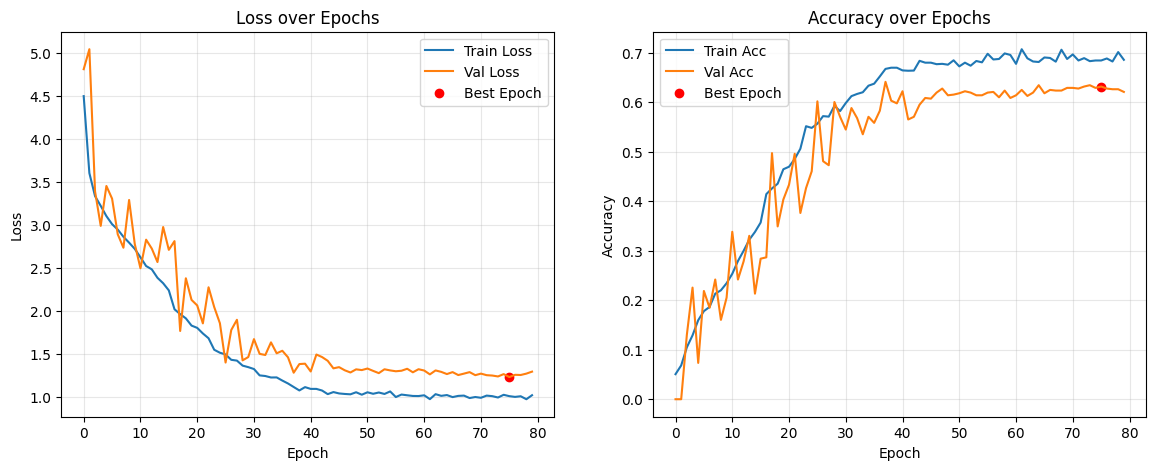

In [ ]:
import pandas as pd

best_model_history_name = "runs/run_20251217_171127_test7_acc63/best_model_history.csv"
if os.path.exists(best_model_history_name):
    # load data
    df = pd.read_csv(best_model_history_name)
    
    # find best epoch based on min validation loss
    best_idx = df['val_loss'].idxmin()
    best_row = df.iloc[best_idx]

    # print stats for the best epoch
    print("--- Best Model Results ---")
    print(f"Best Epoch: {int(best_row['epoch']) + 1}")
    print(f"Val Loss: {best_row['val_loss']:.4f}")
    print(f"Val Accuracy: {best_row['val_accuracy']:.2%}")
    print(f"Train Loss: {best_row['loss']:.4f}")
    print(f"Train Accuracy: {best_row['accuracy']:.2%}")

    # setup figure size
    plt.figure(figsize=(14, 5))

    # plot 1: loss
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['loss'], label='Train Loss')
    plt.plot(df['epoch'], df['val_loss'], label='Val Loss')
    
    # mark the best epoch with a red dot
    plt.scatter(best_row['epoch'], best_row['val_loss'], color='red', label='Best Epoch')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # plot 2: accuracy
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['accuracy'], label='Train Acc')
    plt.plot(df['epoch'], df['val_accuracy'], label='Val Acc')

    # mark the best epoch here too
    plt.scatter(best_row['epoch'], best_row['val_accuracy'], color='red', label='Best Epoch')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

else:
    print(f"File {best_model_history_name} not found.")

## Experimental Results and Design Evolution

To achieve the target accuracy, I conducted a systematic series of experiments, iterating on architecture, hyperparameters, and hardware configurations. The process evolved from simple sequential networks to the final Residual Network implementation.

### Phase 1: Initial Exploration (Unsaved Prototypes)
Before finalizing the architecture, I tested several "lightweight" prototypes to gauge the dataset complexity.
These initial attempts are not present in the <code>runs</code> directory.
<ul>
    <li><b>Preliminary Checks</b>: A simple block <code>Conv2D &rarr; BatchNormalization &rarr; ReLU &rarr; MaxPooling</code> achieved only <b>5%</b> accuracy. Doubling the sub-blocks yielded almost identical results, proving that a superficial network was insufficient.</li>
    <li><b>Test 1 (Sequential Scale-up)</b>: I attempted to increase the network capacity significantly using a sequential structure with filters increasing from <code>16</code> to <code>512</code> and <code>batch_size=4</code>.
    <br><i>Result:</i> The model reached <b>25.14%</b> validation accuracy but suffered from high loss (<code>3.09</code>).
    <br><i>Iteration:</i> Applying more aggressive data augmentation and increasing batch size to <code>6</code> improved the validation accuracy to <b>43.2%</b>. However, the model remained unstable, with training loss significantly lower than validation loss, indicating persistent overfitting issues.</li>
</ul>

### Phase 2: Addressing Overfitting (Tests 2-3)
Recognizing the generalization gap, I focused on regularization strategies applied to the sequential architecture.
<ul>
    <li><b>Test 2 (L2 Regularization)</b>: I applied L2 regularization (<code>0.001</code>) and increased the <code>EarlyStopping</code> patience to <code>20</code>. While the model learned the training set well (<b>77.4%</b> accuracy), it failed to generalize, with validation accuracy dropping to <b>31.9%</b> compared to the unregularized attempt. This gap confirmed <b>overfitting</b>.</li>
    <li><b>Test 3 (Regularization vs. Capacity)</b>: To counter this, I aggressively tuned <code>Dropout</code> (<code>0.25</code> pre/post-pool) and reduced the input image size to <code>128x128</code>. However, performance dropped further (<b>28.5%</b> validation accuracy). It became clear that a simple sequential stack, even when heavily regularized, lacked the representational power for fine-grained pet classification.</li>
</ul>

### Phase 3: The Architectural Shift (Tests 4-5)
<ul>
    <li><b>Test 4 (Vanishing Gradient)</b>: I attempted to simply deepen the network to 6 blocks to capture more complex features. This failed due to the <b>vanishing gradient problem</b>: the signal weakened as it backpropagated, causing the validation loss to remain high (<code>~3.98</code>) and accuracy to stall at <b>28.9%</b>.</li>
    <li><b>Test 5 (Introduction of ResNet)</b>: To solve the gradient issue, I fundamentally changed the architecture to use <b>Residual Learning (Skip Connections)</b>. My first ResNet implementation was lightweight (filters up to <code>256</code>) to conserve memory. However, this resulted in <b>underfitting</b>: the model was too simple to learn the complex features of the dataset, achieving only <b>8.2%</b> validation accuracy.</li>
</ul>

### Phase 4: Scaling Up and Final Convergence (Tests 6-7)
<ul>
    <li><b>Test 6 (The Breakthrough)</b>: I scaled up the ResNet architecture significantly. I introduced a <b>Stem Block</b> for initial feature extraction, doubled the filter count (up to <code>256</code> paired filters), and optimized the pooling strategy to downsample less aggressively. Crucially, switching hardware to a <b>GTX 1080 (8GB)</b> allowed me to increase the batch size to <code>16</code>.<br>
    <i>Result</i>: The model successfully learned, reaching a <b>60.2%</b> validation accuracy. Although this satisfied the project requirements, I realized post-training that I had not enabled the CSV logging, meaning detailed history charts could not be generated for the report.</li>
    <li><b>Test 7 (Documentation & Optimization)</b>: This final test was executed primarily to recover the training history using <code>CSVLogger</code>. <b>Taking advantage of this necessary iteration</b>, I further refined the callbacks (increasing <code>ReduceLROnPlateau</code> patience to <code>5</code> and <code>EarlyStopping</code> patience to <code>15</code>) to allow the model more time to settle.<br>
    <i>Final Result</i>: This refinement yielded a performance boost, increasing validation accuracy to <b>63.18%</b> (loss <code>1.23</code>), proving that the architecture had further margin for improvement.</li>
</ul>

### Note on Model Persistence and Logs

All the trained model checkpoints corresponding to the experiments described above (specifically from <b>Test 2 to Test 7</b>) are physically stored in the <code>task1/runs</code> directory.

However, it is important to clarify that the detailed <b>CSV training logs</b> are available only for <b>Test 7</b>.
During the analysis of <b>Test 6</b>, I realized that the standard model saving format (<code>.keras</code>) does not persist the epoch-by-epoch training history. Consequently, <b>Test 7</b> was conducted specifically to reproduce the results with full data logging via the <code>CSVLogger</code> callback, which allowed for the generation of the detailed metrics graphs presented in this notebook.